In [1]:
import sys
sys.path.append("/global/u2/r/ritesh11/GSOC_2025/")

In [2]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import json

from sklearn.model_selection import train_test_split
from collections import Counter, OrderedDict
from itertools import cycle
import re
import random
from tqdm import tqdm
import warnings

from Flash.tokenizer import Tokenizer, Vocab
from Flash.constants import SPECIAL_SYMBOLS, PAD_IDX, UNK_IDX, T_IDX, BOS_IDX, EOS_IDX, SEP_IDX

In [3]:
def read_file_to_list(file_path):
    lines_list = []
    with open(file_path, 'r') as file:
        for line in file:
            lines_list.append(line.strip())  # .strip() removes newline characters
    return lines_list

In [4]:
parent_dir = "/pscratch/sd/r/ritesh11/raw_data/EW"

In [5]:
process =  ["2-2", "2-3"]
# process = ['EW']
line_list = {}
for p in tqdm(process):
    curr_dir = os.path.join(parent_dir,p)
    temp = [read_file_to_list(os.path.join(curr_dir, file)) for file in os.listdir(curr_dir)]
    line_list[p] = temp

100%|██████████| 2/2 [01:12<00:00, 36.22s/it]


In [6]:
import random
data_list = []

for p in process:
    for lines in line_list[p]:
        temp_list = []
        for c in lines:
            res = c.split(" : ")
            try:
                temp_list.append((res[1], res[2], res[3], p))
            except IndexError:
                pass
            except Exception:
                if len(res) > 2 and "error" not in res[2]:
                    print(res)
                    break
    
        data_list.append(temp_list)

In [7]:
tokenizer = Tokenizer(None, 600, SPECIAL_SYMBOLS, UNK_IDX, True)

In [8]:
src_lens = []
tgt_lens = []
for data in tqdm(data_list, total=len(data_list), desc="processing"):
    src_temp = []
    tgt_temp = []
    for line in data:
        src_temp.append(len(tokenizer.src_tokenize(line[1])))
        tgt_temp.append(len(tokenizer.tgt_tokenize(line[2])))

    src_lens.append(src_temp)
    tgt_lens.append(tgt_temp)

processing: 100%|██████████| 28/28 [04:20<00:00,  9.31s/it]


In [9]:
src_arr = np.array([lens for l in src_lens for lens in l])
tgt_arr = np.array([lens for l in tgt_lens for lens in l])

In [10]:
src_arr.shape

(313499,)

In [11]:
src_arr.mean(), tgt_arr.mean()

(np.float64(339.2200676876162), np.float64(826.7161841026606))

In [12]:
import matplotlib.pyplot as plt

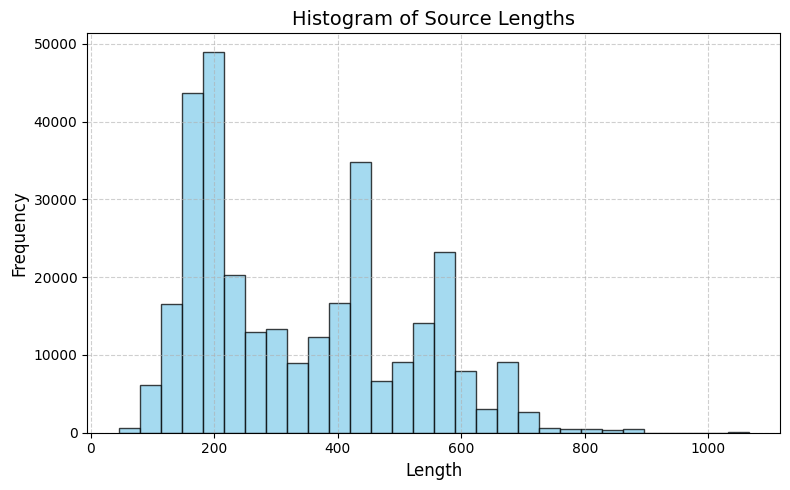

In [13]:
plt.figure(figsize=(8, 5))  # Set figure size

plt.hist(src_arr, bins=30, color='skyblue', edgecolor='black', alpha=0.75)

plt.title("Histogram of Source Lengths", fontsize=14)
plt.xlabel("Length", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()  # Adjust layout to fit labels
plt.show()

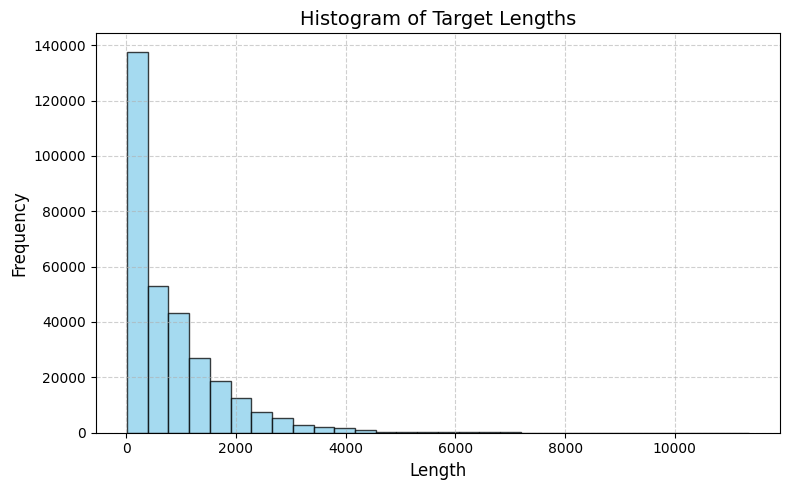

In [14]:
plt.figure(figsize=(8, 5))  # Set figure size

plt.hist(tgt_arr, bins=30, color='skyblue', edgecolor='black', alpha=0.75)

plt.title("Histogram of Target Lengths", fontsize=14)
plt.xlabel("Length", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()  # Adjust layout to fit labels
plt.show()

In [15]:
src_arr.shape

(313499,)

In [16]:
src_arr.mean(), tgt_arr.mean()

(np.float64(339.2200676876162), np.float64(826.7161841026606))

In [17]:
src_arr.max(), tgt_arr.max()

(np.int64(1065), np.int64(11350))

In [18]:
((src_arr < 800) & (tgt_arr < 1200)).sum() 

np.int64(238301)

In [19]:
src_thresh = 800
tgt_thresh = 1200
raw_data_list = []
for data, src_len, tgt_len in zip(data_list, src_lens, tgt_lens):
    temp = []
    for d,s,t in zip(data,src_len,tgt_len):
        if s <= src_thresh and t <= tgt_thresh:
            temp.append(d)
    raw_data_list.append(temp)

In [20]:
for sublist_index, sublist in enumerate(tqdm(raw_data_list, desc="Replacing amp values")):
    for entry_index, entry in enumerate(sublist):
        updated_amp = tokenizer.src_replace(entry[1])
        # Reconstruct the tuple with updated amp, keeping the rest as is
        sublist[entry_index] = (entry[0], updated_amp, *entry[2:])

Replacing amp values: 100%|██████████| 28/28 [00:38<00:00,  1.38s/it]


In [21]:
filtered_data_list = []
for sublist in tqdm(raw_data_list, desc="Removing duplicates"):
    seen_diag_amp = set()
    filtered_sublist = []
    for entry in sublist:
        diag_amp_pair = (entry[0], entry[1])
        if diag_amp_pair not in seen_diag_amp:
            seen_diag_amp.add(diag_amp_pair)
            filtered_sublist.append(entry)
    filtered_data_list.append(filtered_sublist)

Removing duplicates: 100%|██████████| 28/28 [00:00<00:00, 119.70it/s]


In [22]:
filtered_data_list[0][0]

('Vertex V_1:u_R(X_3), AntiPart u_R(X_4),  OffShell A(V_1), Vertex V_0:u_L(X_1), AntiPart u_L(X_2),  OffShell A(V_0),',
 '-2/9*i*e^2*P_L_{ % INDEX_0, % INDEX_1}*P_R_{ % INDEX_2, % INDEX_3}*gamma_{+ %  \\ INDEX_4, % INDEX_5, % INDEX_0}*gamma_{ %  \\ INDEX_4, % INDEX_6, % INDEX_2}*u_L_{PINDEX_0, % INDEX_5}(MOMENTUM_2)_v^(*)*u_L_{PINDEX_1, % INDEX_1}(MOMENTUM_1)_u*u_R_{PINDEX_2, % INDEX_3}(MOMENTUM_4)_v*u_R_{PINDEX_3, % INDEX_6}(MOMENTUM_3)_u^(*)/(m_u^2+MOMENTUM_12+1/2*reg_prop)',
 '16/81*e^4*s_13*s_24*(m_u^2 + s_12 + 1/2*reg_prop)^(-2)',
 '2-2')

In [23]:
from collections import defaultdict, Counter
from tqdm import tqdm

# Step 1: Track sublists in which each diag appears
diag_to_sublists = defaultdict(set)

# Step 2: Track duplicate diags within sublists
within_sublists_dup_count = 0

for sublist_index, sublist in enumerate(tqdm(raw_data_list, desc="Analyzing diag occurrences")):
    diags_in_sublist = [entry[0] for entry in sublist]
    diag_counts = Counter(diags_in_sublist)

    # Add to global mapping
    for diag in diag_counts:
        diag_to_sublists[diag].add(sublist_index)

    # Count diags that occur more than once within this sublist
    within_sublists_dup_count += sum(1 for count in diag_counts.values() if count > 1)

# Step 3: Count diags that appear in more than one sublist
across_sublists_dup_count = sum(1 for sublists in diag_to_sublists.values() if len(sublists) > 1)

# Print results
print(f"Number of diags duplicated *across* sublists: {across_sublists_dup_count}")
print(f"Number of diags duplicated *within* sublists: {within_sublists_dup_count}")

Analyzing diag occurrences: 100%|██████████| 28/28 [00:00<00:00, 76.65it/s]

Number of diags duplicated *across* sublists: 0
Number of diags duplicated *within* sublists: 95998


In [24]:
from collections import defaultdict

# Step 1: Track in which sublists each (diag, amp) pair appears
pair_to_sublists = defaultdict(set)

for sublist_index, sublist in enumerate(tqdm(raw_data_list, desc="Indexing diag-amp pairs")):
    for entry in sublist:
        diag_amp_pair = (entry[0], entry[1])
        pair_to_sublists[diag_amp_pair].add(sublist_index)

# Step 2: Count pairs that appear in more than one sublist
duplicate_pair_count = sum(1 for sublists in pair_to_sublists.values() if len(sublists) > 1)

print(f"Number of (diag, amp) pairs duplicated across sublists: {duplicate_pair_count}")


Indexing diag-amp pairs: 100%|██████████| 28/28 [00:00<00:00, 61.17it/s] 

Number of (diag, amp) pairs duplicated across sublists: 0


In [25]:
total_data = sum(len(sublist) for sublist in filtered_data_list)
# total_data = sum(len({entry[0] for entry in sublist}) for sublist in filtered_data_list)
data_lens = [len(sublist) for sublist in filtered_data_list]

In [26]:
data_dist = [i/total_data for i in data_lens]

In [27]:
all_diags = [entry[0] for datalist in filtered_data_list for entry in datalist]

In [28]:
len(all_diags) == len(set(all_diags))

False

In [29]:
def create_splits_perm(dlist, data_train, data_valid, data_test, total_data, data_prop):
    """
    Split dlist based on unique diag entries into 80/12/8 train/val/test proportions,
    ensuring that all duplicate entries (with same diag) go to the same split to avoid leakage.
    """

    # Step 1: Group all entries by diag
    diag_to_entries = defaultdict(list)
    for entry in dlist:
        diag = entry[0]
        diag_to_entries[diag].append(entry)

    # Step 2: Shuffle the diags to randomize
    unique_diags = list(diag_to_entries.keys())
    random.shuffle(unique_diags)

    # Step 3: Determine number of diags per split
    total_diags = len(unique_diags)
    train_size = int(0.80 * total_diags)
    valid_size = int((total_diags - train_size) * 0.4)
    test_size = total_diags - train_size - valid_size

    # Step 4: Slice diag keys into splits
    train_diags = unique_diags[:train_size]
    valid_diags = unique_diags[train_size:train_size + valid_size]
    test_diags = unique_diags[train_size + valid_size:]

    # Step 5: Assign entries to splits based on diag groups
    for diag in train_diags:
        for entry in diag_to_entries[diag]:
            data_train['diag'].append(entry[0])
            data_train['amp'].append(entry[1])
            data_train['sqamp'].append(entry[2])
            data_train['process'].append(entry[3])

    for diag in valid_diags:
        for entry in diag_to_entries[diag]:
            data_valid['diag'].append(entry[0])
            data_valid['amp'].append(entry[1])
            data_valid['sqamp'].append(entry[2])
            data_valid['process'].append(entry[3])

    for diag in test_diags:
        for entry in diag_to_entries[diag]:
            data_test['diag'].append(entry[0])
            data_test['amp'].append(entry[1])
            data_test['sqamp'].append(entry[2])
            data_test['process'].append(entry[3])

    return data_train, data_valid, data_test

In [30]:
def create_splits_noperm(dlist, data_train, data_valid, data_test, total_data, data_prop):

    filtered_dlist = dlist
    
    # Now work with filtered_dlist
    random.shuffle(filtered_dlist)
    
    # if total_data * 0.80 <= 15000:
    total = len(filtered_dlist)
    train_size = int(0.80 * total)
    valid_size = int((total - train_size) * 0.4)
    test_size = total - train_size - valid_size


    # Assign data to splits
    train_split = filtered_dlist[:train_size]
    valid_split = filtered_dlist[train_size:train_size + valid_size]
    test_split = filtered_dlist[train_size + valid_size:train_size + valid_size + test_size]

    if train_split:
        diag, amp, sq, process = zip(*train_split)
        data_train['diag'].extend(diag)
        data_train['process'].extend(process)
        data_train['amp'].extend(amp)
        data_train['sqamp'].extend(sq)

    if valid_split:
        diag, amp, sq, process = zip(*valid_split)
        data_valid['diag'].extend(diag)
        data_valid['process'].extend(process)
        data_valid['amp'].extend(amp)
        data_valid['sqamp'].extend(sq)

    if test_split:
        diag, amp, sq, process = zip(*test_split)
        data_test['diag'].extend(diag)
        data_test['process'].extend(process)
        data_test['amp'].extend(amp)
        data_test['sqamp'].extend(sq)

    return data_train, data_valid, data_test

In [31]:
data_train = {'sqamp': [], 'process': [], 'amp': [], 'diag': []}
data_valid = {'sqamp': [], 'process': [], 'amp': [], 'diag': []}
data_test = {'sqamp': [], 'process': [], 'amp': [], 'diag': []}

for dlist,prop in zip(filtered_data_list, data_dist):
    data_train, data_valid, data_test = create_splits_perm(dlist, data_train, data_valid, data_test, total_data, prop)

In [32]:
df_train = pd.DataFrame(data_train)
df_test = pd.DataFrame(data_test)
df_valid = pd.DataFrame(data_valid)

In [33]:
df_test

,sqamp,process,amp,diag
0,1/36*v^(-2)*m_u^4*(s_12 + -1/2*m_W3^(-2)*(m_W3...,2-2,-1/6*i*m_u^2*(e*sin(theta_W)/cos(theta_W)+(-3)...,"Vertex V_1:AntiPart u_L(X_2), h(X_3), AntiPart..."
1,1/36*v^(-2)*m_u^4*(s_12 + -1/2*m_W3^(-2)*(m_W3...,2-2,-1/6*i*m_u^2*(e*sin(theta_W)/cos(theta_W)+(-3)...,"Vertex V_1:AntiPart u_L(X_2), h(X_3), AntiPart..."
2,-16/81*e^4*(m_u^2*s_14 + -s_13*s_24 + -s_12*s_...,2-2,"-2/9*i*e^2*P_L_{ % INDEX_0, % INDEX_1}*gamma_{...","Vertex V_0:AntiPart u(X_2), AntiPart u(X_3), ..."
3,1/144*s_14*s_23*(m_u^2 + -1/2*m_W3^2 + -s_13 +...,2-2,1/24*i*(e*sin(theta_W)/cos(theta_W)+(-3)*e*cos...,"Vertex V_1:AntiPart e(X_2), AntiPart e(X_4), ..."
4,1/36*e^2*s_12*s_34*(m_u^2 + -1/2*m_W3^2 + -s_1...,2-2,1/12*i*e*sin(theta_W)*(e*sin(theta_W)/cos(thet...,"Vertex V_1:AntiPart e(X_2), AntiPart e(X_4), ..."
...,...,...,...,...
24622,8/2187*e^4*m_u^4*(s_34 + m_W3^(-2)*(s_23*s_24 ...,2-3,-1/27*i*e^2*m_u^2*sin(theta_W)*(e*sin(theta_W)...,"Vertex V_2:AntiPart u_R(X_3), Z(X_5), OffShel..."
24623,8/2187*e^4*m_u^4*(s_34 + m_W3^(-2)*(s_23*s_24 ...,2-3,-1/27*i*e^2*m_u^2*sin(theta_W)*(e*sin(theta_W)...,"Vertex V_2:AntiPart u_R(X_3), Z(X_5), OffShel..."
24624,-1/4*e^2*v^(-4)*m_e^4*m_u^2*s_24*s_35*(m_e^2 +...,2-3,"-1/4*i*e*v^(-2)*m_e*m_u*(m_e*P_L_{ % INDEX_0, ...","Vertex V_2:AntiPart u(X_5), u_L(X_3), OffShel..."
24625,16/729*i*e^3*(i*e^3*m_u^2*s_15*s_34/((s_12 + 1...,2-3,"2/27*i*e^3*(m_u*P_L_{ % INDEX_0, % INDEX_1}*P_...","Vertex V_1:AntiPart u_L(X_3), OffShell u(V_1)..."


In [34]:
df_train

,sqamp,process,amp,diag
0,16/81*e^4*m_u^2*s_34*(s_23 + -1/2*reg_prop)^(-...,2-2,"4/9*i*e^2*(P_L_{ % INDEX_0, % INDEX_1}*MOMENTU...","Vertex V_0:A(X_2), u_L(X_3), AntiPart OffShel..."
1,16/81*e^4*m_u^2*s_34*(s_23 + -1/2*reg_prop)^(-...,2-2,"4/9*i*e^2*(P_L_{ % INDEX_0, % INDEX_1}*MOMENTU...","Vertex V_0:A(X_2), u_L(X_3), AntiPart OffShel..."
2,16/81*e^4*m_u^2*s_34*(s_23 + -1/2*reg_prop)^(-...,2-2,"4/9*i*e^2*(P_L_{ % INDEX_0, % INDEX_1}*MOMENTU...","Vertex V_0:A(X_2), u_L(X_3), AntiPart OffShel..."
3,1/2592*s_12*s_34*(m_u^2 + -1/2*m_W3^2 + -s_13 ...,2-2,1/72*i*(e*sin(theta_W)/cos(theta_W)+(-3)*e*cos...,"Vertex V_0:AntiPart u(X_2), AntiPart u(X_4), ..."
4,e^4*s_12*s_34*(m_W^2 + -m_d^2 + -m_u^2 + 2*s_2...,2-2,"-1/2*i*e^2*sin(theta_W)^(-2)*P_L_{ % INDEX_0, ...","Vertex V_1:AntiPart d(X_2), AntiPart u_L(X_3),..."
...,...,...,...,...
163831,1/9*e^6*m_e^2*s_15*s_23*(m_e^2 + -1/2*m_W3^2 +...,2-3,1/12*i*e^3*cos(theta_W)^(-2)*sin(theta_W)^2*(P...,"Vertex V_2:e_R(X_3), AntiPart OffShell e_R(V_..."
163832,1/1296*e^2*s_12*s_15*s_34*(s_12 + 1/2*reg_prop...,2-3,-1/144*i*e*(e*sin(theta_W)/cos(theta_W)+3*e*co...,"Vertex V_1:AntiPart d_L(X_3), OffShell d_L(V_..."
163833,1/1296*e^2*s_12*s_15*s_34*(s_12 + 1/2*reg_prop...,2-3,1/144*i*e*(e*sin(theta_W)/cos(theta_W)+3*e*cos...,"Vertex V_1:AntiPart d_L(X_3), OffShell d_L(V_..."
163834,-1/324*e^4*m_d^2*s_23*s_45*(m_d^2 + -1/2*m_W3^...,2-3,-1/72*i*e^2*sin(theta_W)*(e*sin(theta_W)/cos(t...,"Vertex V_2:AntiPart d_R(X_3), OffShell d_R(V_..."


In [35]:
len(set(df_test.diag))

13153

In [36]:
len(set(df_train.diag))

87561

In [37]:
len(set(df_test.sqamp))

11581

In [38]:
diags_train = list(set(df_train.diag))
diags_test = list(set(df_test.diag))  # <- corrected from df_train to df_test

In [39]:
common_diags = set(diags_train) & set(diags_test)
print(f"Number of common diags: {len(common_diags)}")

Number of common diags: 0


In [40]:
# df_train['amp'] = df_train['amp'].map(tokenizer.src_replace)
# df_valid['amp'] = df_valid['amp'].map(tokenizer.src_replace)
# df_test['amp'] = df_test['amp'].map(tokenizer.src_replace)

df_train['sqamp'] = df_train['sqamp'].map(tokenizer.tgt_replace)
df_valid['sqamp'] = df_valid['sqamp'].map(tokenizer.tgt_replace)
df_test['sqamp'] = df_test['sqamp'].map(tokenizer.tgt_replace)

In [41]:
df_train.amp[0]

'4/9*i*e^2*(P_L_{ % INDEX_0, % INDEX_1}*MOMENTUM_1_ %  \\ INDEX_2*gamma_{ %  \\ INDEX_3, % INDEX_4, % INDEX_0}*A_{PINDEX_0,+ %  \\ INDEX_3}(MOMENTUM_2)*A_{PINDEX_1,+ %  \\ INDEX_2}(MOMENTUM_4)^(*)*u_L_{PINDEX_2, % INDEX_1}(MOMENTUM_1)_u*u_L_{PINDEX_3, % INDEX_4}(MOMENTUM_3)_u^(*)+-1/2*m_u*P_R_{ % INDEX_5, % INDEX_6}*gamma_{ %  \\ INDEX_3, % INDEX_7, % INDEX_8}*gamma_{ %  \\ INDEX_2, % INDEX_8, % INDEX_5}*A_{PINDEX_0,+ %  \\ INDEX_3}(MOMENTUM_2)*A_{PINDEX_1,+ %  \\ INDEX_2}(MOMENTUM_4)^(*)*u_L_{PINDEX_2, % INDEX_6}(MOMENTUM_1)_u*u_L_{PINDEX_3, % INDEX_7}(MOMENTUM_3)_u^(*)+-1/2*P_L_{ % INDEX_9, % INDEX_10}*MOMENTUM_4_ %  \\ INDEX_11*gamma_{+ %  \\ INDEX_11, % INDEX_12, % INDEX_13}*gamma_{ %  \\ INDEX_3, % INDEX_14, % INDEX_12}*gamma_{ %  \\ INDEX_2, % INDEX_13, % INDEX_9}*A_{PINDEX_0,+ %  \\ INDEX_3}(MOMENTUM_2)*A_{PINDEX_1,+ %  \\ INDEX_2}(MOMENTUM_4)^(*)*u_L_{PINDEX_2, % INDEX_10}(MOMENTUM_1)_u*u_L_{PINDEX_3, % INDEX_14}(MOMENTUM_3)_u^(*))/(MOMENTUM_23+-1/2*reg_prop)'

In [42]:
df_train.sqamp[0]

'16/81*e^4*m_u^2*MOMENTUM_34*(MOMENTUM_23+-1/2*reg_prop)^(-2)+16/81*e^4*MOMENTUM_14*MOMENTUM_34*(MOMENTUM_23+-1/2*reg_prop)^(-2)+-8/81*i*e^2*m_u*(i*e^2*m_u*MOMENTUM_13/(MOMENTUM_23+-1/2*reg_prop)+(-4)*i*e^2*m_u*MOMENTUM_34/(MOMENTUM_23+-1/2*reg_prop))/(MOMENTUM_23+-1/2*reg_prop)'

In [43]:
df_train.shape, df_valid.shape, df_test.shape

((163836, 4), (16485, 4), (24627, 4))

In [44]:
df_train.to_csv("EW_2-2-3_1kcutofftrain.csv",index=False)
df_test.to_csv("EW_2-2-3_1kcutofftest.csv",index=False)
df_valid.to_csv("EW_2-2-3_1kcutoffvalid.csv",index=False)

In [3]:
df = pd.read_csv("EW_2-2-3test.csv")

In [4]:
tokenizer = Tokenizer(df, 600, SPECIAL_SYMBOLS, UNK_IDX, False)

In [5]:
src_vocab = tokenizer.build_src_vocab()

Processing source vocab: 100%|██████████| 10624/10624 [00:02<00:00, 5157.13it/s]


In [47]:
sorted(old)

['%',
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '/',
 '1',
 '108',
 '12',
 '144',
 '16',
 '18',
 '2',
 '216',
 '24',
 '27',
 '3',
 '36',
 '4',
 '432',
 '48',
 '5',
 '54',
 '6',
 '72',
 '8',
 '9',
 'A_{',
 'CONJ',
 'INDEX_0',
 'INDEX_1',
 'INDEX_10',
 'INDEX_11',
 'INDEX_12',
 'INDEX_13',
 'INDEX_14',
 'INDEX_15',
 'INDEX_16',
 'INDEX_17',
 'INDEX_18',
 'INDEX_19',
 'INDEX_2',
 'INDEX_20',
 'INDEX_21',
 'INDEX_22',
 'INDEX_23',
 'INDEX_24',
 'INDEX_25',
 'INDEX_26',
 'INDEX_27',
 'INDEX_28',
 'INDEX_29',
 'INDEX_3',
 'INDEX_30',
 'INDEX_31',
 'INDEX_32',
 'INDEX_4',
 'INDEX_5',
 'INDEX_6',
 'INDEX_7',
 'INDEX_8',
 'INDEX_9',
 'MOMENTUM_1',
 'MOMENTUM_12',
 'MOMENTUM_13',
 'MOMENTUM_14',
 'MOMENTUM_1_',
 'MOMENTUM_2',
 'MOMENTUM_23',
 'MOMENTUM_24',
 'MOMENTUM_2_',
 'MOMENTUM_3',
 'MOMENTUM_34',
 'MOMENTUM_35',
 'MOMENTUM_3_',
 'MOMENTUM_4',
 'MOMENTUM_45',
 'MOMENTUM_4_',
 'MOMENTUM_5',
 'MOMENTUM_5_',
 'PINDEX_0',
 'PINDEX_1',
 'PINDEX_2',
 'PINDEX_3',
 'PINDEX_4',
 'P_L_{',
 'P_R_{',
 'W_{

In [40]:
df_train

,sqamp,process,amp
0,-4/81*e^4*(m_d^2*MOMENTUM_13+-MOMENTUM_14*MOME...,"Vertex V_1:d(X_2), d(X_4), OffShell A(V_1), V...","1/9*i*e^2*P_L_{ % INDEX_0, % INDEX_1}*gamma_{+..."
1,-1/18*e^4*m_d^2*(MOMENTUM_13+-1/2*m_W^(-2)*(m_...,"Vertex V_0:A(X_2), d_L(X_3), AntiPart OffShel...","1/12*i*2^(1/2)*e^2*(P_L_{ % INDEX_0, % INDEX_1..."
2,1/162*e^2*MOMENTUM_13*MOMENTUM_24*(m_u^2+-1/2*...,"Vertex V_1:u(X_2), u(X_3), OffShell Z(V_1), V...",-1/18*i*e*sin(theta_W)*(e*sin(theta_W)/cos(the...
3,2/3*e^4*m_u^2*MOMENTUM_14*(1+1/2*m_W3^(-4)*MOM...,"Vertex V_1:AntiPart u_L(X_1), AntiPart u(X_4),...",-i*e^2*m_u*(1+1/2*cos(theta_W)^(-2)*sin(theta_...
4,e^4*MOMENTUM_13*MOMENTUM_24*(m_W^2+-m_d^2+-m_u...,"Vertex V_1:d_L(X_4), u_L(X_1), OffShell W(V_1...","-1/2*i*e^2*sin(theta_W)^(-2)*P_L_{ % INDEX_0, ..."
...,...,...,...
186867,1/486*e^2*v^(-2)*m_d^4*(m_d^2*MOMENTUM_14+-1/2...,"Vertex V_2:h(X_5), AntiPart d_L(X_4), OffShel...",-1/36*i*e*m_d*(e*sin(theta_W)/cos(theta_W)+3*e...
186868,1/162*i*e^3*(i*e^3*m_d^2*MOMENTUM_14*MOMENTUM_...,"Vertex V_1:AntiPart d_R(X_3), OffShell d(V_1)...","1/36*i*e^3*(P_R_{ % INDEX_0, % INDEX_1}*P_R_{ ..."
186869,2/9*i*e*v^(-2)*m_u^3*(i*e*v^(-2)*m_u^3*MOMENTU...,"Vertex V_1:AntiPart u_R(X_3), OffShell u(V_1)...","-1/3*i*e*v^(-2)*m_u^2*P_L_{ % INDEX_0, % INDEX..."
186870,4/81*i*e^2*m_u^2*(i*e^2*m_u^4*MOMENTUM_34/(v*(...,"Vertex V_2:AntiPart u_R(X_3), h(X_5), OffShel...","-1/9*i*e^2*m_u*(m_u*P_R_{ % INDEX_0, % INDEX_1..."


In [52]:
import importlib

# Reimport your custom modules
import Flash.tokenizer
import Flash.constants

# Reload them to reflect any changes made
importlib.reload(Flash.tokenizer)
importlib.reload(Flash.constants)

# Now re-import the specific objects if needed
from Flash.tokenizer import Tokenizer, Vocab
from Flash.constants import SPECIAL_SYMBOLS, PAD_IDX, UNK_IDX, T_IDX, BOS_IDX, EOS_IDX, SEP_IDX

In [53]:
len(T_IDX)

20

In [54]:
src_vocab = Vocab(src_vocab,SPECIAL_SYMBOLS,BOS_IDX,PAD_IDX,EOS_IDX,UNK_IDX,SEP_IDX,T_IDX)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [57]:
src_vocab.tokens()

['<S>',
 '<PAD>',
 '</S>',
 '<UNK>',
 '<SEP>',
 '<T_0>',
 '<T_1>',
 '<T_2>',
 '<T_3>',
 '<T_4>',
 '<T_5>',
 '<T_6>',
 '<T_7>',
 '<T_8>',
 '<T_9>',
 '<T_10>',
 '<T_11>',
 '<T_12>',
 '<T_13>',
 '<T_14>',
 '<T_15>',
 '<T_16>',
 '<T_17>',
 '<T_18>',
 '<T_19>',
 ',',
 'e',
 'U',
 '4',
 '08',
 'L',
 '\\',
 'C',
 'r',
 'm',
 '/',
 'M',
 'v',
 'R',
 '6',
 't',
 '5',
 'n',
 '(',
 'a',
 'o',
 'X',
 'W',
 's',
 '{',
 'N',
 'i',
 'O',
 'D',
 '8',
 '+',
 'E',
 '_',
 '1',
 '^',
 'd',
 '7',
 'T',
 'h',
 'J',
 'I',
 'p',
 'Z',
 'PI',
 'c',
 '2',
 '9',
 '-',
 '*',
 '}',
 ')',
 'P',
 'u',
 '3',
 'A',
 '0',
 'g',
 '%']

In [44]:
test = src_vocab.encode(tokenizer.src_tokenize(df_train.amp[0]))

In [50]:
"".join(src_vocab.decode([1]*10 + [0]*5 + test))

'-1/2*i*e^2*sin(theta_W)^(-2)*P_L_{%INDEX_0,%INDEX_1}*P_L_{%INDEX_2,%INDEX_3}*gamma_{+%\\INDEX_4,%INDEX_5,%INDEX_0}*gamma_{%\\INDEX_4,%INDEX_6,%INDEX_2}*d_{PINDEX_0,%INDEX_1}(MOMENTUM_4)_v*d_{PINDEX_1,%INDEX_6}(MOMENTUM_2)_v^CONJ*u_L_{PINDEX_2,%INDEX_3}(MOMENTUM_3)_v*u_L_{PINDEX_3,%INDEX_5}(MOMENTUM_1)_v^CONJ/(m_W^2+-m_d^2+-m_u^2+2*MOMENTUM_23+-reg_prop)'

In [51]:
df_train.amp[0]

'-1/2*i*e^2*sin(theta_W)^(-2)*P_L_{ % INDEX_0, % INDEX_1}*P_L_{ % INDEX_2, % INDEX_3}*gamma_{+ %  \\ INDEX_4, % INDEX_5, % INDEX_0}*gamma_{ %  \\ INDEX_4, % INDEX_6, % INDEX_2}*d_{PINDEX_0, % INDEX_1}(MOMENTUM_4)_v*d_{PINDEX_1, % INDEX_6}(MOMENTUM_2)_v^(*)*u_L_{PINDEX_2, % INDEX_3}(MOMENTUM_3)_v*u_L_{PINDEX_3, % INDEX_5}(MOMENTUM_1)_v^(*)/(m_W^2+-m_d^2+-m_u^2+2*MOMENTUM_23+-reg_prop)'